Wandb Report Link: 
https://wandb.ai/drbean/MLP-classification/reports/Question-2-2--Vmlldzo1NzkwOTU1

In [87]:
import sys
import wandb
import warnings
import numpy as np
import pandas as pd

from prettytable import PrettyTable
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MultiLabelBinarizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [53]:
data = pd.read_csv('WineQT.csv')
data.drop_duplicates(inplace=True)
data = data.drop(columns=['Id'])
# print(data.shape)

# Dataset Analysis and Preprocessing
columns = data.columns
t = PrettyTable(['Attribute', 'Mean', 'Standard Deviation', 'min Value', 'max value'])
for attr in columns:
    col = data[attr]
    mean = round(col.mean(), 4)
    std = round(col.std(), 4)
    t.add_row([attr, mean, std, col.min(), col.max()])
print(t)

+----------------------+---------+--------------------+-----------+-----------+
|      Attribute       |   Mean  | Standard Deviation | min Value | max value |
+----------------------+---------+--------------------+-----------+-----------+
|    fixed acidity     |  8.3111 |       1.7476       |    4.6    |    15.9   |
|   volatile acidity   |  0.5313 |       0.1796       |    0.12   |    1.58   |
|     citric acid      |  0.2684 |       0.1967       |    0.0    |    1.0    |
|    residual sugar    |  2.5322 |       1.3559       |    0.9    |    15.5   |
|      chlorides       |  0.0869 |       0.0473       |   0.012   |   0.611   |
| free sulfur dioxide  | 15.6155 |      10.2505       |    1.0    |    68.0   |
| total sulfur dioxide | 45.9147 |      32.7821       |    6.0    |   289.0   |
|       density        |  0.9967 |       0.0019       |  0.99007  |  1.00369  |
|          pH          |  3.311  |       0.1567       |    2.74   |    4.01   |
|      sulphates       |  0.6577 |      

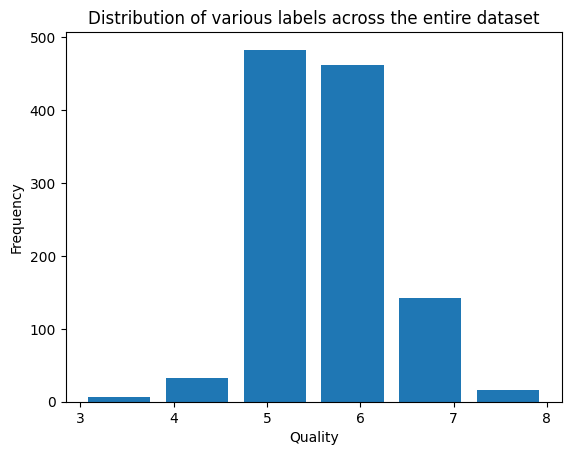

In [54]:
# Distribution of various labels across the entire dataset
labels = data['quality']
plt.hist(labels, bins=len(np.unique(labels)), rwidth=0.8)
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Distribution of various labels across the entire dataset')
plt.show()

In [69]:
# Split the data into attributes and labels
X = data.iloc[:,data.columns != 'quality']
Y = data['quality']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Apply Normalization to the attributes
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Apply Standardization to the attributes
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert labels into one-hot vectors
Y = Y - Y.min()
temp = np.zeros((Y.size, Y.max()+1))
temp[np.arange(Y.size), Y] = 1
Y = temp

# Split the data into train, test and validation sets
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, train_size=0.7, stratify=Y)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp)

In [14]:
class Network:
    def __init__(self, layers, activation, learn_rate=0.01):
        self.weights = []
        self.bias = []
        self.num = len(layers)-1
        self.batch_size = 1
        self.layers = layers
        self.func = activation
        self.rate = learn_rate
        
        for i in range(len(layers)-1):
            w = np.random.rand(layers[i], layers[i+1])
            self.weights.append(w / np.sqrt(layers[i]))
            self.bias.append(np.zeros((1, layers[i+1])))
        
    def set_activation(self, activation):
        self.func = activation

    def set_learn_rate(self, learn_rate):
        self.rate = learn_rate

    def set_algorithm(self, algorithm):
        self.batch_size = algorithm[1]

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def activation(self, x):
        if self.func == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        if self.func == 'tanh':
            return np.tanh(x)
        if self.func == 'ReLU':
            return np.maximum(0, x)
        
    def activation_gradient(self, x):
        if self.func == 'sigmoid':
            return np.exp(-x) / ((1 + np.exp(-x))**2)
        if self.func == 'tanh':
            return 1 - np.tanh(x)**2
        if self.func == 'ReLU':
            return np.where(x > 0, 1, 0)
        
    def batch(self, X, Y):
        n = self.batch_size
        for idx in range(0, len(X), n):
            yield X[idx:min(idx+n, len(X))], Y[idx:min(idx+n, len(X))]
        
    def fit(self, x_train, y_train, n_epochs=1000):
        for _ in range(n_epochs):
            for (x_batch, y_batch) in self.batch(x_train, y_train):
                self.fit_instant(x_batch, y_batch)

    def fit_wandb(self, x_train, y_train, x_valid, y_valid, n_epochs=1000):
        for _ in range(n_epochs):
            for (x_batch, y_batch) in self.batch(x_train, y_train):
                self.fit_instant(x_batch, y_batch)
            y_pred = self.predict(x_valid)
            loss = self.calculate_loss(y_valid, y_pred)
            accuracy = self.accuracy(y_valid, y_pred)
            wandb.log({"Loss": loss, "Accuracy": accuracy})

    def fit_instant(self, x, y):
        # forward pass
        y_pred, z_pred = [x], [np.zeros_like(x)]
        for layer in range(self.num):
            z = np.dot(y_pred[layer], self.weights[layer]) + self.bias[layer]
            if layer==self.num-1: y_pred.append(self.softmax(z))
            else: y_pred.append(self.activation(z))
            z_pred.append(z)

        # backward pass
        error = y_pred[-1]-y
        derivatives = [error]
        for layer in range(self.num-1, 0, -1):
            delta = np.dot(derivatives[-1], self.weights[layer].T)
            delta = delta * self.activation_gradient(z_pred[layer])
            derivatives.append(delta)

        # update the weights
        derivatives = derivatives[::-1]
        for layer in range(self.num):
            self.weights[layer] += -self.rate * np.dot(y_pred[layer].T, derivatives[layer])
            self.bias[layer] += -self.rate * np.sum(derivatives[layer], axis=0, keepdims=True)

    def calculate_loss(self, y_true, y_pred, epsilon=1e-12):
        n = y_true.shape[0]
        y_pred = np.clip(y_pred, epsilon, 1-epsilon)
        loss = -np.sum(y_true * np.log(y_pred+1e-9)) / n
        return loss
    
    def predict(self, x):
        values = [x]
        for layer in range(self.num):
            z = np.dot(values[layer], self.weights[layer]) + self.bias[layer]
            if layer==self.num-1: values.append(self.softmax(z))
            else: values.append(self.activation(z))
        return values[-1]
    
    def accuracy(self, y_true, y_pred):
        true_labels = np.argmax(y_true, axis=1)
        pred_labels = np.argmax(y_pred, axis=1)
        accuracy = np.mean(true_labels == pred_labels)
        return accuracy

In [56]:
def get_nodes(num, mini, maxi):
    layer = []
    layer.append(x_train.shape[1])
    for _ in range(num):
        k = np.random.randint(mini, maxi)
        layer.append(k)
    layer.append(y_train.shape[1])
    return layer

def get_scores(actual, predicted):
    y_true = np.argmax(actual, axis=1)
    y_pred = np.argmax(predicted, axis=1)
    fone = f1_score(y_true, y_pred, zero_division=0, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0, average='weighted')
    recall = recall_score(y_true, y_pred, zero_division=0, average='weighted')
    return [round(fone, 4), round(accuracy, 4), round(precision, 4), round(recall, 4)]

In [16]:
wandb.login()

True

In [17]:
activations = ['sigmoid', 'tanh', 'ReLU']
algorithms = [['SGD', 1], ['BGD', x_train.shape[0]], ['MBGD', 32]]

t =PrettyTable(['Activation', 'Optimizer', 'F1-score', 'Accuracy', 'Precision', 'Recall'])
for activation in activations:
    for algo in algorithms:
        str = 'act:{} opt:{}'.format(activation, algo[0])
        wandb.init(project="MLP-classification", config={"activation": activation, "optimizer": algo[0]}, name=str)
        layer = get_nodes(5, 10, 11)
        model = Network(layer, activation, 0.01)
        model.set_algorithm(algo)
        model.fit_wandb(x_train, y_train, x_valid, y_valid, 1000)

        y_pred = model.predict(x_valid)
        scores = get_scores(y_valid, y_pred)
        t.add_row([activation, algo[0]]+scores)
        wandb.finish()
print(t)

Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▇▇▇▇▇▇█▇▇▇██
Loss,████████████████████████████▆▂▂▁▁▁▁▁▁▁▁▂
Accuracy,0.63743
Loss,0.97611


Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.40351
Loss,1.89471


Accuracy,▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▆▆▇▇▇▇▇▇▇██▇▇▇
Loss,██████████████████████████▇▅▂▂▁▁▁▁▁▁▁▁▂▂
Accuracy,0.61404
Loss,0.95691


Accuracy,▆▅▅▃▃▅▄▃▂▁▃▃▃▃▄▅▄▆▃▃▄▃▆▃▆▅▆▅▆▃▄▂▃▃▅█▂▅▃▅
Loss,▁▂▂▃▃▄▅▅▆▇▆▅▇▇▇▇▆█▆▆▇▇▅▅▇▅▇▃▄▇▅▇██▅▆▆▄▅▅
Accuracy,0.55556
Loss,1.37342


Accuracy,▆▆▆▆▁▅▆█▅▅▁▆▂▅▅▃▆▃▆▆▆██▅▆▁▆▆█▆▆▃▆█▃▅▆██▃
Loss,▆▅▆▆▅▄▆▅▁▆▄▆▅▅▃▇▆█▆▆▅▄▄▆▂▅▆▅▅▆▆▆▆▅▂▆▆▄▄▆
Accuracy,0.34503
Loss,12.30548


Accuracy,▅▅▆▅▆▄▅▅▅▇▆▄▄▅▅▄▅▄▅▄▁▄▂▄▅▂▄▃▅▃▅▄▅█▄▅▆▆▂▃
Loss,▁▁▁▃▃▄▄▃▃▃▃▅▅▄▃▅▃▄▅▅█▇▅▆▅▆▄▄▄▅▅▃▄▁▄▃▂▂▆▃
Accuracy,0.64327
Loss,1.09534


Accuracy,▆▆▆▆▇▆▆▇█▆▆▅▆▆▆▇▅▆▅▇▅▆▇▆▇▄▄▆▇▁▅█▆▇▆▆▄▇▆▅
Loss,▁▁▁▁▁▂▂▃▂▃▃▄▄▅▄▅▆▇▅▅▅▇▄▅▆▅█▅▇▂▂▂▂▄▂▃▂▃▃▄
Accuracy,0.5848
Loss,1.47117


Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,▁███████████████████████████████████████
Accuracy,0.40351
Loss,1.89471


Accuracy,▇▆▆█▇▄▄▆▅▃▂▁▅▄▅▄▆▇▃▅▅▅▃▅▅▆▆▆▅▅▄▄▄▅▂▅▅▄▃▄
Loss,▁▁▁▁▂▂▂▃▂▄▄▄▃▆▅▅▄▃▆▃▅▅▅▃▆▃▇██▄▂▂▂▂▄▂▂▃▂▂
Accuracy,0.54386
Loss,1.02436


+------------+-----------+----------+----------+-----------+--------+
| Activation | Optimizer | F1-score | Accuracy | Precision | Recall |
+------------+-----------+----------+----------+-----------+--------+
|  sigmoid   |    SGD    |   0.62   |  0.6374  |   0.6063  | 0.6374 |
|  sigmoid   |    BGD    |  0.232   |  0.4035  |   0.1628  | 0.4035 |
|  sigmoid   |    MBGD   |  0.5967  |  0.614   |   0.5829  | 0.614  |
|    tanh    |    SGD    |  0.5383  |  0.5556  |   0.524   | 0.5556 |
|    tanh    |    BGD    |  0.2341  |  0.345   |   0.1772  | 0.345  |
|    tanh    |    MBGD   |  0.6289  |  0.6433  |   0.6176  | 0.6433 |
|    ReLU    |    SGD    |  0.5659  |  0.5848  |   0.5492  | 0.5848 |
|    ReLU    |    BGD    |  0.232   |  0.4035  |   0.1628  | 0.4035 |
|    ReLU    |    MBGD   |  0.4834  |  0.5439  |   0.4407  | 0.5439 |
+------------+-----------+----------+----------+-----------+--------+


In [70]:
learn_rate = [0.1, 0.01, 0.001]
hidden_layers = [10, 25, 50]
epochs = [100, 1000]

t = PrettyTable(['#Epochs', 'Learning Rate', 'Hidden neurons', 'F1-score', 'Accuracy', 'Precision', 'Recall'])
for n_epochs in epochs:
    for rate in learn_rate:
        for layer in hidden_layers:
            layers = get_nodes(5, layer, layer+1)
            model = Network(layers, 'tanh', rate)
            model.set_algorithm(['MBGD', 32])
            model.fit(x_train, y_train, n_epochs)

            y_pred = model.predict(x_valid)
            scores = get_scores(y_valid, y_pred)
            t.add_row([n_epochs, rate, layer]+scores)
print(t)

+---------+---------------+----------------+----------+----------+-----------+--------+
| #Epochs | Learning Rate | Hidden neurons | F1-score | Accuracy | Precision | Recall |
+---------+---------------+----------------+----------+----------+-----------+--------+
|   100   |      0.1      |       10       |  0.0269  |  0.1228  |   0.0151  | 0.1228 |
|   100   |      0.1      |       25       |  0.385   |  0.4327  |   0.3573  | 0.4327 |
|   100   |      0.1      |       50       |  0.2495  |  0.4211  |   0.1773  | 0.4211 |
|   100   |      0.01     |       10       |  0.6135  |  0.6316  |   0.5992  | 0.6316 |
|   100   |      0.01     |       25       |   0.55   |  0.5614  |   0.5511  | 0.5614 |
|   100   |      0.01     |       50       |  0.4065  |  0.4503  |   0.3705  | 0.4503 |
|   100   |     0.001     |       10       |  0.5521  |  0.5673  |   0.5502  | 0.5673 |
|   100   |     0.001     |       25       |  0.5153  |  0.5731  |   0.4694  | 0.5731 |
|   100   |     0.001     |     

In [74]:
# Evaluate the model on test dataset
layer = get_nodes(5, 10, 11)
model = Network(layers, 'tanh', 0.01)
model.set_algorithm(['MBGD', 32])
model.fit(x_train, y_train, 100)

y_pred = model.predict(x_test)
report = classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.70      0.77      0.73        73
           3       0.53      0.71      0.61        69
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00         2

    accuracy                           0.61       172
   macro avg       0.21      0.25      0.22       172
weighted avg       0.51      0.61      0.55       172



Wandb Report Link: 
https://wandb.ai/drbean/MLP-multilabel/reports/Question-2-4--Vmlldzo1NzkwOTQ1

In [88]:
class MultiNetwork:
    def __init__(self, layers, activation, learn_rate=0.01):
        self.weights = []
        self.bias = []
        self.num = len(layers)-1
        self.batch_size = 1
        self.layers = layers
        self.func = activation
        self.rate = learn_rate
        
        for i in range(len(layers)-1):
            w = np.random.rand(layers[i], layers[i+1])
            self.weights.append(w / np.sqrt(layers[i]))
            self.bias.append(np.zeros((1, layers[i+1])))
        
    def set_activation(self, activation):
        self.func = activation

    def set_learn_rate(self, learn_rate):
        self.rate = learn_rate

    def set_algorithm(self, algorithm):
        self.batch_size = algorithm[1]

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_gradient(self, x):
        return np.exp(-x) / ((1 + np.exp(-x))**2)
    
    def activation(self, x):
        if self.func == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        if self.func == 'tanh':
            return np.tanh(x)
        if self.func == 'ReLU':
            return np.maximum(0, x)
        
    def activation_gradient(self, x):
        if self.func == 'sigmoid':
            return np.exp(-x) / ((1 + np.exp(-x))**2)
        if self.func == 'tanh':
            return 1 - np.tanh(x)**2
        if self.func == 'ReLU':
            return np.where(x > 0, 1, 0)
        
    def batch(self, X, Y):
        n = self.batch_size
        for idx in range(0, len(X), n):
            yield X[idx:min(idx+n, len(X))], Y[idx:min(idx+n, len(X))]
        
    def fit(self, x_train, y_train, n_epochs=1000):
        for _ in range(n_epochs):
            for (x_batch, y_batch) in self.batch(x_train, y_train):
                self.fit_instant(x_batch, y_batch)

    def fit_wandb(self, x_train, y_train, x_valid, y_valid, n_epochs=1000):
        for _ in range(n_epochs):
            for (x_batch, y_batch) in self.batch(x_train, y_train):
                self.fit_instant(x_batch, y_batch)
            y_pred = self.predict(x_valid)
            loss = self.calculate_loss(y_valid, y_pred)
            accuracy = self.accuracy(y_valid, y_pred)
            wandb.log({"Loss": loss, "Accuracy": accuracy})

    def fit_instant(self, x, y):
        # forward pass
        y_pred, z_pred = [x], [np.zeros_like(x)]
        for layer in range(self.num):
            z = np.dot(y_pred[layer], self.weights[layer]) + self.bias[layer]
            if layer==self.num-1: y_pred.append(self.sigmoid(z))
            else: y_pred.append(self.activation(z))
            z_pred.append(z)

        # backward pass
        error = y_pred[-1]-y
        derivatives = [error*self.sigmoid_gradient(y_pred[-1])]
        for layer in range(self.num-1, 0, -1):
            delta = np.dot(derivatives[-1], self.weights[layer].T)
            delta = delta * self.activation_gradient(z_pred[layer])
            derivatives.append(delta)

        # update the weights
        derivatives = derivatives[::-1]
        for layer in range(self.num):
            self.weights[layer] += -self.rate * np.dot(y_pred[layer].T, derivatives[layer])
            self.bias[layer] += -self.rate * np.sum(derivatives[layer], axis=0, keepdims=True)

    def calculate_loss(self, y_true, y_pred, epsilon=1e-12):
        n = y_true.shape[0]
        y_pred = np.clip(y_pred, epsilon, 1-epsilon)
        loss = -np.sum(y_true * np.log(y_pred+1e-9) + (1-y_true) * np.log(1-y_pred+1e-9)) / n
        return loss
    
    def predict(self, x):
        values = [x]
        for layer in range(self.num):
            z = np.dot(values[layer], self.weights[layer]) + self.bias[layer]
            if layer==self.num-1: values.append(self.sigmoid(z))
            else: values.append(self.activation(z))
        return values[-1]
    
    def accuracy(self, y_true, y_pred, threshold=0.5):
        y_pred = (y_pred >= threshold).astype(int)
        return 1-hamming_loss(y_true, y_pred)

In [89]:
def encode_label(vec):
    labels = []
    for x in vec:
        temp = []
        for y in x.split():
            temp.append(y)
        labels.append(temp)
    mlb = MultiLabelBinarizer()
    y_labels = mlb.fit_transform(labels)
    return y_labels

def preprocess_data(data):
    names = list(data.columns)
    names[9] = 'most_brought_item'
    data.columns = names

    # one hot encoding
    X = data.iloc[:,0:10]
    X = X.drop(columns=['city'])
    Y = data.iloc[:,10]
    crt = ['gender', 'education', 'married', 'occupation', 'most_brought_item']
    X = pd.get_dummies(X, columns=crt)
    Y = encode_label(Y)
    return X, Y

In [90]:
# Load the data and preprocess it
data = pd.read_csv('advertisement.csv')
X, Y = preprocess_data(data)

# Split the data into train, test and validation sets
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, train_size=0.7)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

def print_results(actual, predicted):
    result = get_scores(actual, predicted)
    t = PrettyTable(['Measure', 'Value'])
    t.add_row(['F1-score', result[0]])
    t.add_row(['Accuracy', result[1]])
    t.add_row(['Precision', result[2]])
    t.add_row(['Recall', result[3]])
    print(t)

In [91]:
activations = ['sigmoid', 'tanh', 'ReLU']
algorithms = [['SGD', 1], ['BGD', x_train.shape[0]], ['MBGD', 32]]

t = PrettyTable(['Activation', 'Optimizer', 'F1-score', 'Accuracy', 'Precision', 'Recall'])
for activation in activations:
    for algo in algorithms:
        str = 'act:{} opt:{}'.format(activation, algo[0])
        wandb.init(project="MLP-multilabel", config={"activation": activation, "optimizer": algo[0]}, name=str)
        layer = get_nodes(5, 10, 11)
        model = MultiNetwork(layer, activation, 0.01)
        model.set_algorithm(algo)
        model.fit_wandb(x_train, y_train, x_valid, y_valid, 1000)

        y_pred = model.predict(x_valid)
        scores = get_scores(y_valid, y_pred)
        t.add_row([activation, algo[0]]+scores)
        wandb.finish()
print(t)

Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Accuracy,0.64417
Loss,5.22628


Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.64417
Loss,5.22545


Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,███▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Accuracy,0.64417
Loss,5.22647


Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,█▇▆▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
Accuracy,0.64417
Loss,5.22602


Accuracy,██▅█▁▅███▄███▄▄▄▅▄▄████▅████▅███████▄██▄
Loss,▁▂▃▄▅▅▄▆▄▄█▄▅▆▃▆▃▄▆▂▂▂▅▃▂▅▅▂▄▂▂▅▂▂▄▂▂▂▂▂
Accuracy,0.64417
Loss,13.32713


Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.64417
Loss,5.22588


Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,▁███████████████████████████████████████
Accuracy,0.64417
Loss,5.22603


Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.64417
Loss,5.22545


Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,▁███████████████████████████████████████
Accuracy,0.64417
Loss,5.22609


+------------+-----------+----------+----------+-----------+--------+
| Activation | Optimizer | F1-score | Accuracy | Precision | Recall |
+------------+-----------+----------+----------+-----------+--------+
|  sigmoid   |    SGD    |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|  sigmoid   |    BGD    |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|  sigmoid   |    MBGD   |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|    tanh    |    SGD    |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|    tanh    |    BGD    |  0.0008  |   0.02   |   0.0004  |  0.02  |
|    tanh    |    MBGD   |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|    ReLU    |    SGD    |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|    ReLU    |    BGD    |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|    ReLU    |    MBGD   |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
+------------+-----------+----------+----------+-----------+--------+


In [92]:
learn_rate = [0.1, 0.01, 0.001]
hidden_layers = [10, 25, 50]
epochs = [100, 1000]

t = PrettyTable(['#Epochs', 'Learning Rate', 'Hidden neurons', 'F1-score', 'Accuracy', 'Precision', 'Recall'])
for n_epochs in epochs:
    for rate in learn_rate:
        for layer in hidden_layers:
            layers = get_nodes(5, layer, layer+1)
            model = MultiNetwork(layers, 'ReLU', rate)
            model.set_algorithm(['MBGD', 32])
            model.fit(x_train, y_train, n_epochs)

            y_pred = model.predict(x_valid)
            scores = get_scores(y_valid, y_pred)
            t.add_row([n_epochs, rate, layer]+scores)
print(t)

+---------+---------------+----------------+----------+----------+-----------+--------+
| #Epochs | Learning Rate | Hidden neurons | F1-score | Accuracy | Precision | Recall |
+---------+---------------+----------------+----------+----------+-----------+--------+
|   100   |      0.1      |       10       |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|   100   |      0.1      |       25       |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|   100   |      0.1      |       50       |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|   100   |      0.01     |       10       |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|   100   |      0.01     |       25       |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|   100   |      0.01     |       50       |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|   100   |     0.001     |       10       |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|   100   |     0.001     |       25       |  0.1667  |  0.3333  |   0.1111  | 0.3333 |
|   100   |     0.001     |     

In [96]:
# Evaluate the model on test dataset
layer = get_nodes(5, 25, 26)
model = Network(layers, 'ReLU', 0.01)
model.set_algorithm(['MBGD', 32])
model.fit(x_train, y_train, 100)

y_pred = model.predict(x_test)
print_results(y_test, y_pred)

+-----------+--------+
|  Measure  | Value  |
+-----------+--------+
|  F1-score | 0.1331 |
|  Accuracy | 0.2933 |
| Precision | 0.086  |
|   Recall  | 0.2933 |
+-----------+--------+
